In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model

In [7]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
data_dir = "food_dataset" 
categories = os.listdir(data_dir)

image_size = (224, 224) 
batch_size = 32

# Data Generator
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2  # 20% for validation
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

Found 1145 images belonging to 25 classes.
Found 284 images belonging to 25 classes.


In [ ]:
from PIL import Image
import os

data_dir = "food_dataset"

for root, _, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        try:
            img = Image.open(file_path)
            img.verify()  
        except (IOError, SyntaxError):
            print(f"File gambar rusak ditemukan dan dihapus: {file_path}")
            os.remove(file_path)

In [4]:
augmented_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [8]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.1542 - loss: 3.0105 - val_accuracy: 0.6444 - val_loss: 1.4516
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 857ms/step - accuracy: 0.5673 - loss: 1.4970 - val_accuracy: 0.7711 - val_loss: 0.8498
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 868ms/step - accuracy: 0.7415 - loss: 0.9021 - val_accuracy: 0.8134 - val_loss: 0.6684
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 878ms/step - accuracy: 0.8210 - loss: 0.7001 - val_accuracy: 0.8099 - val_loss: 0.5957
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 898ms/step - accuracy: 0.8374 - loss: 0.5372 - val_accuracy: 0.8486 - val_loss: 0.4968
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 894ms/step - accuracy: 0.8776 - loss: 0.4200 - val_accuracy: 0.8662 - val_loss: 0.4702
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 891ms/step - accuracy: 0.8724 - loss: 0.4063 - val_accuracy: 0.8873 - val_loss: 0.4402
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9226 - loss: 0.3149 - val_accuracy: 

In [ ]:
model.save('best_model.h5')
print("Model berhasil disimpan sebagai 'best_model.h5'")

Model berhasil disimpan sebagai 'best_model.h5'


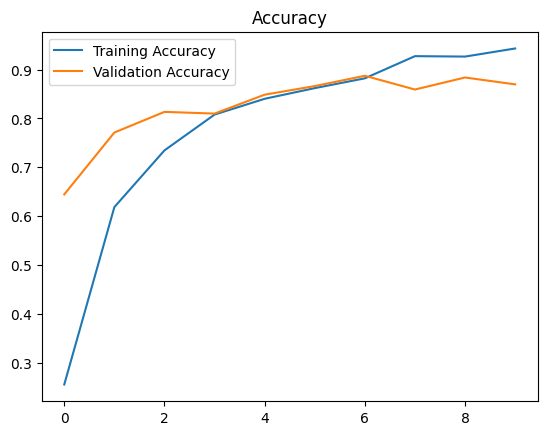

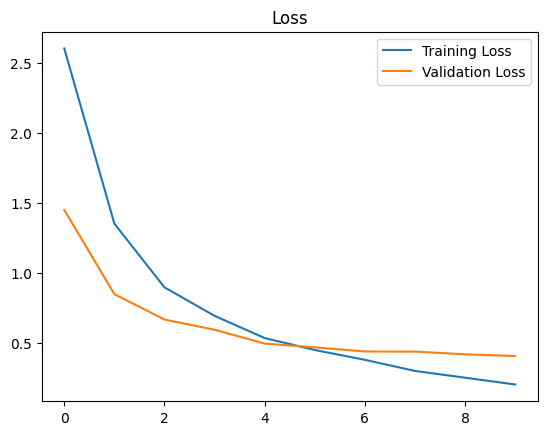

In [9]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from tkinter import Tk, filedialog
from PIL import Image

# Function for prediction based on model and input image
def predict_food_interactive(model, train_generator, nutrition_info):
    Tk().withdraw() 
    file_path = filedialog.askopenfilename(title="Pilih gambar makanan", filetypes=[("Image files", "*.jpg;*.jpeg;*.png")])
    
    if not file_path:
        print("Tidak ada file gambar yang dipilih!")
        return
    
    # Preprocessing images
    img = load_img(file_path, target_size=(224, 224)) 
    x = img_to_array(img) / 255.0 
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])

    # Prediction with model
    classes = model.predict(images, batch_size=1)
    predicted_class_index = np.argmax(classes)

    # Search the label based on index
    label_name = list(filter(lambda x: train_generator.class_indices[x] == predicted_class_index, train_generator.class_indices))[0]

    nutrition = nutrition_info.get(label_name, "Informasi nutrisi tidak tersedia.")

    print(f"Gambar: {file_path}")
    print(f"Prediksi: {label_name}")
    print(f"Informasi Nutrisi: {nutrition}")